In [1]:
import os
import torch
import torchaudio
import librosa
import numpy as np
import matplotlib.pyplot as plt
from torchaudio.transforms import TimeStretch, AmplitudeToDB, ComplexNorm
from torch.distributions import Uniform
from torch import nn
from torchvision import datasets, transforms


In [2]:
class SpecNormalization(nn.Module):

    def __init__(self, norm_type, top_db=80.0):

        super(SpecNormalization, self).__init__()

        if 'db' == norm_type:
            self._norm = AmplitudeToDB(stype='power', top_db=top_db)
        elif 'whiten' == norm_type:
            self._norm = lambda x: self.z_transform(x)
        else:
            self._norm = lambda x: x
        
    
    def z_transform(self, x):
        # Independent mean, std per batch
        non_batch_inds = [1, 2]
        mean = x.mean(non_batch_inds, keepdim=True)
        std = x.std(non_batch_inds, keepdim=True)
        x = (x - mean)/std 
        return x

    def forward(self, x):
        return self._norm(x)

    
class RandomTimeStretch(TimeStretch):

    def __init__(self, max_perc, hop_length=None, n_freq=201, fixed_rate=None):

        super(RandomTimeStretch, self).__init__(hop_length, n_freq, fixed_rate)
        self._dist = Uniform(1.-max_perc, 1+max_perc)

    def forward(self, x):
        rate = self._dist.sample().item()
        return super(RandomTimeStretch, self).forward(x, rate), rate

In [3]:
folder = "/media/yuigahama/ssd/datasets/birdcall/train_resampled/aldfly/"
filename = folder + "XC189264.wav"

Shape of waveform: torch.Size([1, 2497725])
Sample rate of waveform: 32000


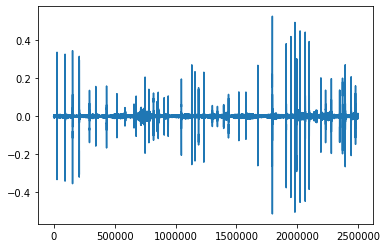

In [4]:
waveform, sample_rate = torchaudio.load(filename,normalization=True)

print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))

plt.figure()
plt.plot(waveform.t().numpy())

In [5]:
waveform[0].unsqueeze(0).size()

torch.Size([1, 2497725])

In [6]:
waveform

tensor([[0., 0., 0.,  ..., 0., 0., 0.]])

for flie_name in os.listdir(folder):
    path = folder + flie_name
    waveform, sample_rate = torchaudio.load(path)
    mel_specgram = torchaudio.transforms.MelSpectrogram(sample_rate, n_fft=2**11)(waveform)
    plt.figure()
    plt.imshow(
        AmplitudeToDB(top_db=80)(mel_specgram)[0].detach().numpy()[::-1],
        cmap='magma', extent=[0,700,0,100], aspect=4)
    plt.savefig("./pics/"+flie_name+".png", format='png')
    plt.close()

In [7]:
n_fft = 2**11
mel = torchaudio.transforms.MelSpectrogram(sample_rate=sample_rate, n_fft=n_fft, n_mels=128)
norm = SpecNormalization('whiten')
random_stretch = RandomTimeStretch(0.4,None,n_fft//2+1,fixed_rate=None)

specgram = torchaudio.transforms.Spectrogram(hop_length=None,power=None, n_fft=n_fft)(waveform)
specgram, rate = random_stretch(specgram)
specgram = ComplexNorm(power=2.)(specgram)
print(specgram.size())

torch.Size([1, 1025, 1820])


Shape of spectrogram: torch.Size([1, 201, 12489])


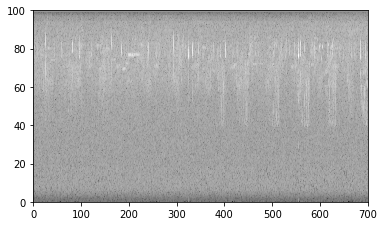

In [24]:
#specgram = torchaudio.transforms.Spectrogram(power=None)(waveform)
specgram = torchaudio.transforms.Spectrogram()(waveform)
print("Shape of spectrogram: {}".format(specgram.size()))

plt.figure()
p = plt.imshow(specgram.log2()[0,:,:].detach().numpy(), cmap='gray', extent=[0,700,0,100], aspect=4)

Shape of spectrogram: torch.Size([1, 128, 2440])


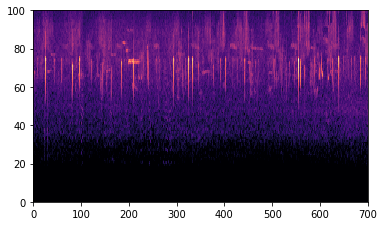

In [9]:
#specgram = torchaudio.transforms.Spectrogram(power=None)(waveform)
mel_specgram = torchaudio.transforms.MelSpectrogram(sample_rate, n_fft=2**11, f_max=8000)(waveform)
mel_specgram= AmplitudeToDB(top_db=80)(mel_specgram)
print("Shape of spectrogram: {}".format(mel_specgram.size()))

plt.figure()
p = plt.imshow(mel_specgram[0].detach().numpy()[::-1], cmap='magma', extent=[0,700,0,100], aspect=4)

In [ ]:
class RondomDtretch(nn.Module):
    def __init__(self, n_fft=2**11, max_perc=0.4):
        self.time_stretch = TimeStretch(hop_length=None, n_freq=n_fft//2+1)
        self.stft = Spectrogram(n_fft=n_fft, power=None)
        self.com_norm = ComplexNorm(power=2.)
        self.mel_specgram = MelSpectrogram(sample_rate, n_fft=n_fft, f_max=8000)
        self.AtoDB= AmplitudeToDB(top_db=80)
        self.dist = Uniform(1.-max_perc, 1+max_perc)
    
    def forward(self, x):
        x = self.stft(x)
        x = self.time_stretch(x, self.dist.sample().item())
        x = self.com_norm(x)
        x = self.mel_specgram.mel_scale(x)
        x = self.AtoDB(x)
        
        size = x.size()
        
        if size[2] > 157:
            x = x[:,:,0:157]
        else:
            x = torch.cat([x, torch.zeros([size[0], size[1], 157 - size[2]], dim=2)
        
        return x

In [116]:
t = torchaudio.transforms.TimeStretch(hop_length=None, n_freq=2**11//2+1)
specgram = torchaudio.transforms.Spectrogram(n_fft=2**11, power=None)(waveform[:, 0:sample_rate*5])
com_norm = ComplexNorm(power=2.)
mel_specgram = torchaudio.transforms.MelSpectrogram(sample_rate, n_fft=2**11, f_max=8000)
AtoDB= AmplitudeToDB(top_db=80)

In [117]:
specgram = t(specgram, 1.4)
specgram = com_norm(specgram)
specgram = mel_specgram.mel_scale(specgram)
specgram = AtoDB(specgram)
torch.tensor(specgram.size())

tensor([  1, 128, 113])

In [113]:
if specgram.size(2) > 157:
    specgram = specgram[:,:,0:157]
else:
    size = 
    specgram = torch.cat([specgram, torch.zeros([specgram.size(0),specgram.size(1), 157 - specgram.size(2)])], dim=2)
specgram.size()

torch.Size([1, 128, 157])

In [114]:
specgram

tensor([[[-44.6901, -42.9548, -43.0626,  ...,   0.0000,   0.0000,   0.0000],
         [-44.6901, -44.6901, -44.6901,  ...,   0.0000,   0.0000,   0.0000],
         [-44.6901, -44.6901, -44.6901,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [-44.6901, -22.2039, -21.8299,  ...,   0.0000,   0.0000,   0.0000],
         [-44.6901, -26.0731, -24.0554,  ...,   0.0000,   0.0000,   0.0000],
         [-44.6901, -26.0044, -24.9413,  ...,   0.0000,   0.0000,   0.0000]]])

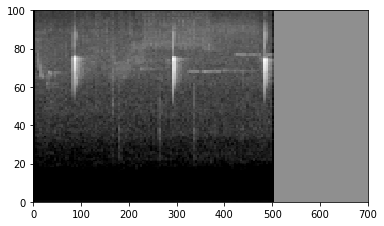

In [115]:
plt.figure()
p = plt.imshow(specgram[0].detach().numpy()[::-1], cmap='gray', extent=[0,700,0,100], aspect=4)

Shape of spectrogram: torch.Size([1, 128, 157])


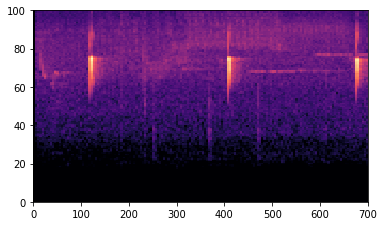

In [93]:
mel_specgram = torchaudio.transforms.MelSpectrogram(sample_rate, n_fft=2**11, f_max=8000)(waveform[:, 0:sample_rate*5])
mel_specgram= AmplitudeToDB(top_db=80)(mel_specgram)
print("Shape of spectrogram: {}".format(mel_specgram.size()))

plt.figure()
p = plt.imshow(mel_specgram[0].detach().numpy()[::-1], cmap='magma', extent=[0,700,0,100], aspect=4)

In [81]:
specgram.size()

torch.Size([1, 128, 314])

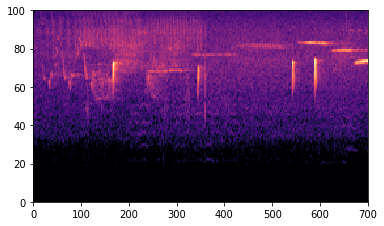

In [40]:
select = np.random.randint(0, 2440 - 256)
plt.figure()
p = plt.imshow(mel_specgram[:,:,select:select+256][0].detach().numpy()[::-1], cmap='magma', extent=[0,700,0,100], aspect=4)

In [98]:
Uniform(1.-0.4, 1+0.4)

Uniform(low: 0.6000000238418579, high: 1.399999976158142)

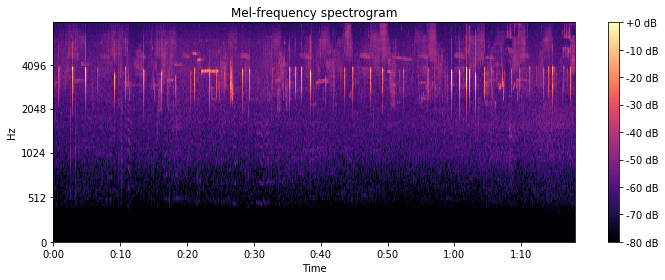

In [24]:
import librosa.display
y, sr = librosa.load(filename)
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128,fmax=8000)
plt.figure(figsize=(10, 4))
S_dB = librosa.power_to_db(S, ref=np.max)
librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=sr,
                         fmax=8000)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-frequency spectrogram')
plt.tight_layout()
plt.show()

Shape of transformed waveform: torch.Size([1, 64450])


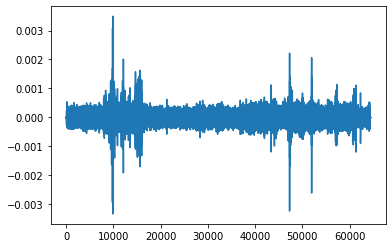

In [8]:
new_sample_rate = sample_rate/10

# Since Resample applies to a single channel, we resample first channel here
channel = 0
transformed = torchaudio.transforms.Resample(sample_rate, new_sample_rate)(waveform[channel,:].view(1,-1))

print("Shape of transformed waveform: {}".format(transformed.size()))

plt.figure()
plt.plot(transformed[0,:].numpy())

In [9]:
# Let's check if the tensor is in the interval [-1,1]
print("Min of waveform: {}\nMax of waveform: {}\nMean of waveform: {}".format(waveform.min(), waveform.max(), waveform.mean()))


Min of waveform: -0.573760986328125
Max of waveform: 0.574676513671875
Mean of waveform: -1.5234592865454033e-05


In [10]:
def normalize(tensor):
    # Subtract the mean, and scale to the interval [-1,1]
    tensor_minusmean = tensor - tensor.mean()
    return tensor_minusmean/tensor_minusmean.abs().max()

# Let's normalize to the full interval [-1,1]
# waveform = normalize(waveform)

Shape of transformed waveform: torch.Size([1, 644494])


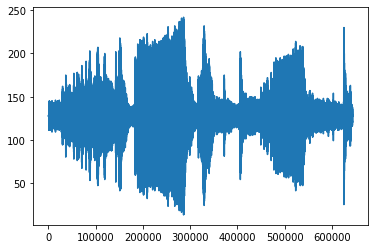

In [11]:
transformed = torchaudio.transforms.MuLawEncoding()(waveform)

print("Shape of transformed waveform: {}".format(transformed.size()))

plt.figure()
plt.plot(transformed[0,:].numpy())


Shape of recovered waveform: torch.Size([1, 644494])


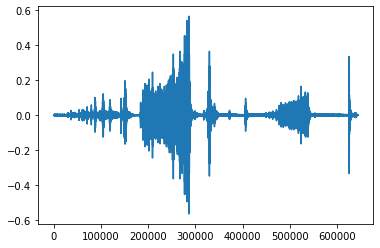

In [12]:
reconstructed = torchaudio.transforms.MuLawDecoding()(transformed)

print("Shape of recovered waveform: {}".format(reconstructed.size()))

plt.figure()
plt.plot(reconstructed[0,:].numpy())

In [13]:
# Compute median relative difference
err = ((waveform-reconstructed).abs() / waveform.abs()).median()

print("Median relative difference between original and MuLaw reconstucted signals: {:.2%}".format(err))


Median relative difference between original and MuLaw reconstucted signals: 2.63%


Shape of transformed waveform: torch.Size([1, 644494])


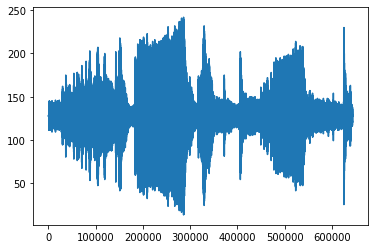

In [14]:
mu_law_encoding_waveform = torchaudio.functional.mu_law_encoding(waveform, quantization_channels=256)

print("Shape of transformed waveform: {}".format(mu_law_encoding_waveform.size()))

plt.figure()
plt.plot(mu_law_encoding_waveform[0,:].numpy())

Shape of computed deltas: torch.Size([1, 128, 3223])


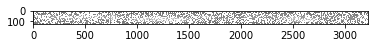

In [15]:
computed = torchaudio.functional.compute_deltas(specgram.contiguous(), win_length=3)
print("Shape of computed deltas: {}".format(computed.shape))

plt.figure()
plt.imshow(computed.log2()[0,:,:].detach().numpy(), cmap='gray')

In [16]:
gain_waveform = torchaudio.functional.gain(waveform, gain_db=5.0)
print("Min of gain_waveform: {}\nMax of gain_waveform: {}\nMean of gain_waveform: {}".format(gain_waveform.min(), gain_waveform.max(), gain_waveform.mean()))

dither_waveform = torchaudio.functional.dither(waveform)
print("Min of dither_waveform: {}\nMax of dither_waveform: {}\nMean of dither_waveform: {}".format(dither_waveform.min(), dither_waveform.max(), dither_waveform.mean()))

Min of gain_waveform: -1.0203073024749756
Max of gain_waveform: 1.0219354629516602
Mean of gain_waveform: -2.709135878831148e-05
Min of dither_waveform: -0.573699951171875
Max of dither_waveform: 0.574676513671875
Mean of dither_waveform: 1.116068304440887e-07


Min of lowpass_waveform: -0.18801778554916382
Max of lowpass_waveform: 0.18498818576335907
Mean of lowpass_waveform: -1.5234589227475226e-05


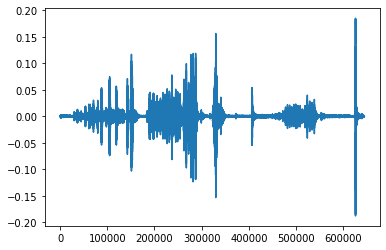

In [17]:
lowpass_waveform = torchaudio.functional.lowpass_biquad(waveform, sample_rate, cutoff_freq=3000)

print("Min of lowpass_waveform: {}\nMax of lowpass_waveform: {}\nMean of lowpass_waveform: {}".format(lowpass_waveform.min(), lowpass_waveform.max(), lowpass_waveform.mean()))

plt.figure()
plt.plot(lowpass_waveform.t().numpy())

Min of highpass_waveform: -0.5949044823646545
Max of highpass_waveform: 0.5779889822006226
Mean of highpass_waveform: -9.488451691019861e-11


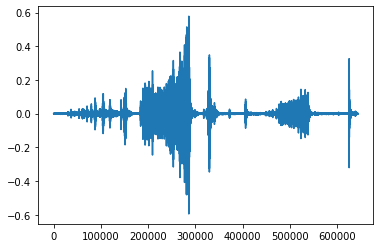

In [18]:
highpass_waveform = torchaudio.functional.highpass_biquad(waveform, sample_rate, cutoff_freq=2000)

print("Min of highpass_waveform: {}\nMax of highpass_waveform: {}\nMean of highpass_waveform: {}".format(highpass_waveform.min(), highpass_waveform.max(), highpass_waveform.mean()))

plt.figure()
plt.plot(highpass_waveform.t().numpy())

Shape of spectrogram: torch.Size([3221, 201])


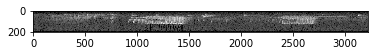

In [56]:
n_fft = 400.0
frame_length = n_fft / sample_rate * 1000.0
frame_shift = frame_length / 2.0

params = {
    "channel": 0,
    "dither": 0.0,
    "window_type": "hanning",
    "frame_length": frame_length,
    "frame_shift": frame_shift,
    "remove_dc_offset": False,
    "round_to_power_of_two": False,
    "sample_frequency": sample_rate,
}

specgram = torchaudio.compliance.kaldi.spectrogram(waveform, **params)

print("Shape of spectrogram: {}".format(specgram.size()))

plt.figure()
plt.imshow(specgram.t().numpy(), cmap='gray')

Shape of fbank: torch.Size([3221, 23])


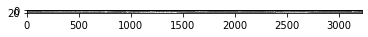

In [20]:
fbank = torchaudio.compliance.kaldi.fbank(waveform, **params)

print("Shape of fbank: {}".format(fbank.size()))

plt.figure()
plt.imshow(fbank.t().numpy(), cmap='gray')


Shape of mfcc: torch.Size([3221, 13])


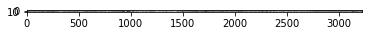

In [21]:
mfcc = torchaudio.compliance.kaldi.mfcc(waveform, **params)

print("Shape of mfcc: {}".format(mfcc.size()))

plt.figure()
plt.imshow(mfcc.t().numpy(), cmap='gray')

Waveform: tensor([[-3.0518e-05,  6.1035e-05,  3.0518e-05,  ..., -1.9836e-03,
         -1.6785e-03, -2.0142e-03]])
Sample rate: 8000
Labels: [0, 1, 1, 1, 1, 0, 1, 0]


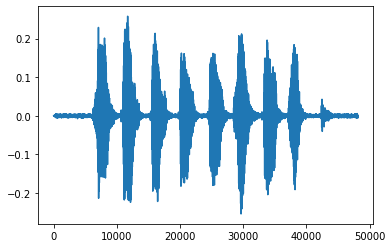

In [38]:
yesno_data = torchaudio.datasets.YESNO('./', download=True)

# A data point in Yesno is a tuple (waveform, sample_rate, labels) where labels is a list of integers with 1 for yes and 0 for no.

# Pick data point number 3 to see an example of the the yesno_data:
n = 3
waveform, sample_rate, labels = yesno_data[n]

print("Waveform: {}\nSample rate: {}\nLabels: {}".format(waveform, sample_rate, labels))

plt.figure()
plt.plot(waveform.t().numpy())
